# ゲート付きRNN

RNN層にゲートと呼ばれる機構を追加し、より長期的な文脈の情報を保持できるようにしたもの。

In [1]:
import math
import random

import sentencepiece as spm
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
from dlprog import train_progress
import matplotlib.pyplot as plt

In [2]:
prog = train_progress(
    width=20,
    with_test=True,
    label="ppl train",
    round=2,
    agg_fn=lambda s, w: math.exp(s / w)
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### 学習データの用意

In [3]:
textfile = f"data/jawiki.txt"
tokenizer_prefix = f"models/tokenizer_jawiki"

In [4]:
with open(textfile) as f:
    data = f.read().splitlines()

In [5]:
sp = spm.SentencePieceProcessor(f"{tokenizer_prefix}.model")
n_vocab = len(sp)

unk_id = sp.unk_id()
bos_id = sp.bos_id()
eos_id = sp.eos_id()
pad_id = sp.pad_id()

data_ids = sp.encode(data)
for ids in data_ids:
    ids.insert(0, bos_id)
    ids.append(eos_id)

print("num of vocabrary:", n_vocab)
data_ids[0][:10] # example

num of vocabrary: 8000


[1, 13, 20, 491, 540, 276, 48, 762, 53, 3649]

In [6]:
class TextDataset(Dataset):
    def __init__(self, data_ids):
        self._n_samples = len(data_ids)
        self.data = [torch.tensor(ids) for ids in data_ids]

    def __getitem__(self, idx):
        in_text = self.data[idx][:-1]
        out_text = self.data[idx][1:]
        return in_text, out_text

    def __len__(self):
        return self._n_samples

def collate_fn(batch):
    in_text, out_text = zip(*batch)
    in_text = pad_sequence(in_text, batch_first=True, padding_value=pad_id)
    out_text = pad_sequence(out_text, batch_first=True, padding_value=pad_id)
    return in_text, out_text

batch_size = 32
dataset = TextDataset(data_ids)
train_dataset, test_dataset = random_split(dataset, [0.8, 0.2])
print("num of train data:", len(train_dataset))
print("num of test data:", len(test_dataset))

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=collate_fn
)

sample_x, sample_y = next(iter(train_loader))
sample_x.shape, sample_y.shape

num of train data: 71760
num of test data: 17939


(torch.Size([32, 1275]), torch.Size([32, 1275]))


---

## 勾配消失

RNNは勾配消失という問題を抱える。勾配消失とは、逆伝播の際に、層が深くなる（出力層から離れる）につれて勾配が小さくなる現象である。

RNNでは時間方向に勾配消失が起こる。ある時刻$t$における損失を小さくする勾配が、それよりも前の時刻$t'<t$に伝わりづらく、届く勾配が小さくなる。また$t'$が$t$と離れているほど勾配が小さくなり、その差が大きい場合、$t'$と$t$の依存関係を学習することが困難になる。

また別の解釈をすると、勾配とはその変数が出力値に与える影響と捉えられ、勾配が小さいということは、簡単に言うとその変数が機能していないことを表す。RNNにおける勾配消失とは、$t$における出力値$y_t$に対して$t'$のパラメータや入力が機能していない状態となるため、$t'$の情報を考慮して$y_t$を出力することが困難になる。

勾配消失が起こる原因を見ていく。RNNでは全結合とtanhを繰り返すので、BPTTではその微分を繰り返しかけることとなる。

tanhの微分は$1-y^2$である。$-1<y<1$なので微分は0~1の間に収まる。BPTTの際はこの1より小さな値が何度も掛けられることになるので、次第に勾配が小さくなる。

全結合も見てみる。重み行列を$W$とすると、BPTTではその転置$W^T$が勾配に繰り返しかけられることとなる。このとき、多くの場合で勾配は次第に小さくなる。（$W$の特異値が1を超えていると大きくなることもある。）

このように、基本的には次第に勾配が小さくなる。

ちなみに、全結合で勾配が大きくなり、それがtanhによる勾配の減少を上回ると、勾配が次第に大きくなる**勾配爆発**という現象が起きる。勾配爆発では勾配がオーバーフローを起こしてしまうことがあるため、勾配の絶対値に上限を設ける勾配クリッピングという手法で解決を図る。

勾配消失が起こっている状況を実際に見てみよう。適当なRNNで演算を行い、時刻ごとの勾配を見てみる。

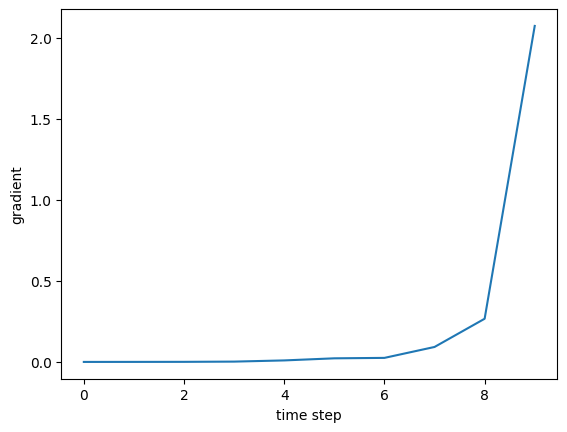

In [ ]:
batch_size, seq_len, hidden_size = 1, 10, 5
rnn = nn.RNN(hidden_size, hidden_size, batch_first=True)
x = torch.randn(batch_size, seq_len, hidden_size, requires_grad=True)
_, h = rnn(x)
h.sum().backward()
grad, = x.grad.abs().sum(-1)
plt.plot(grad.detach().numpy())
plt.xlabel("time step")
plt.ylabel("gradient");

時刻が戻るにつれ勾配が小さくなっているのが分かる。


---

## ゲート

あるデータをどれくらい通すかを示したもの。具体的には、0~1の要素を持つ、対象のデータと同じサイズのベクトル。

例えば、$z=(0.2,0.5,0.9)$というゲートは一つ目の要素を2割、二つ目の要素を5割、三つ目の要素を9割通すゲートである。

In [7]:
z = torch.tensor([0.2, 0.5, 0.9])

このゲートに適当なデータとして3次元ベクトル$x=(1,2,3)$を掛けてみる。

In [8]:
x = torch.tensor([1, 2, 3])
y = x * z
y

tensor([0.2000, 1.0000, 2.7000])

これで、元の入力$x$の**一部を通した**ことになった。これがゲートの役目。

### ニューラルネットワークにゲートを取り入れる

NNにゲートを取り入れることを考える。ゲートを一つの層として挟むといった感じ。まあRNNでない普通のNNにゲートを取り入れることはあまりないのだけれど。RNNに取り入れることを学ぶためのステップとして読んで欲しいかな。

NNにゲートを取り入れる場合、以下のような形が考えられる。

$$
\begin{align}
\tilde h &= h \odot z \\
z &= \text{gate}(h) = \sigma(\text{fc}(h))
\end{align}
$$

ゲートへの入力$h$に対し、適当な関数$\text{gate}$を用いてゲート$z$を作り、$h$と$z$の要素ごとの積をとることで出力$\tilde h$を生成する。ゲートを作る関数は基本的に全結合層$\text{fc}$とシグモイド関数$\sigma$を組み合わせて作る。もちろんこの全結合層は学習可能。その全結合層によって線形変換したのち、シグモイド関数によって0~1の値に収める。$h$を次の層にどれだけ通すかを学習する層ということ。

ゲート部分を実装すると以下。

In [ ]:
class Gate(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, input_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
input_size = 3
gate = Gate(input_size)

x = torch.randn(input_size) # 適当な入力
gate_x = gate(x)
print("input:", x)
print("gate:", gate_x)

y = x * gate_x
print("output:", y)

data: tensor([-1.8377,  0.7763, -0.8717])
gate: tensor([0.7910, 0.6489, 0.8707], grad_fn=<SigmoidBackward0>)
output: tensor([-1.4536,  0.5037, -0.7590], grad_fn=<MulBackward0>)


このような形でRNNにゲートを取り入れる。具体的な構造は次節以降で。


---

## GRU

*Gated Recurrent Unit*

ゲート付きRNNの一種。割とシンプルなモデル。

一旦RNNの復習をしよう。


RNNはある時間$t$の入力$x_t$に対して以下のような演算で出力値$h_t$を決定する。

$$
h_t = \mathrm{tanh}(W_x x_t + b_x + W_h h_{t-1} + b_h)
$$

この$x_t$と$h_{t-1}$の全結合の部分をまとめて、一つの全結合$\mathrm{fc}(x,h)$で表すことにしよう。

$$
\begin{align}
h_t &= \mathrm{tanh}(\mathrm{fc}(x_t,h_{t-1})) \\
\mathrm{fc}(x,h) &= W_x x + b_x + W_h h + b_h
\end{align}
$$

ついでに$\mathrm{fc}(x,h)$の実装もしておこう。

In [11]:
class FullyConnected(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.fc_input = nn.Linear(input_size, hidden_size)
        self.fc_hidden = nn.Linear(hidden_size, hidden_size)

    def forward(self, x, h):
        return self.fc_input(x) + self.fc_hidden(h)

では、GRUの構造を見ていこう。GRUは以下のような演算で出力値$h_t$を決定する。

$$
\begin{align}
h_t &= (1 - z_t) \odot \tilde{h}_t + z_t \odot h_{t-1} \\
\tilde{h}_t &= \mathrm{tanh}(\mathrm{fc}_{\tilde h}(x_t,h_{t-1})) \\
z_t &= \text{gate}(x_t,h_{t-1}) = \sigma(\mathrm{fc}_{z}(x_t,h_{t-1})) \\
\end{align}
$$

$\sigma(x)$はsigmoid関数。**なお、このGRUは一般的なものより少し簡略化されているので注意。**

RNNでは新たなデータ$\tilde h_t$がそのまま出力されていたが、GRUでは、新たなデータ$\tilde h_t$を古いデータ$h_{t-1}$に足して出力する。そして、その際の比率をゲート$z_t$で決める。$z_t$は$h_{t-1}$をどれだけ通すかを表すもので、$x_t$と$h_{t-1}$によって決まる。

このように、GRUではゲートを用いて新たなデータをどれだけ取り入れるべきか、そして古いデータをどれだけ捨てるか考えることが出来る。この枠組みの下で学習を行うことで、長期的に保持すべきデータをしっかりと保持できるようになることが期待される。

単一時間のGRUを実装してみよう。まずGRU内部で用いるゲートをつくる。

In [12]:
class Gate(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.fc = FullyConnected(input_size, hidden_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, h):
        return self.sigmoid(self.fc(x, h))

$x$と$h$の二つを入力するので`nn.Sequential`は使えない。

でこれを使ってGRUを実装するとこう。

In [13]:
class SimpleGRUCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.fc = FullyConnected(input_size, hidden_size)
        self.gate = Gate(input_size, hidden_size)

    def forward(self, x, h):
        h_new = F.tanh(self.fc(x, h))
        z = self.gate(x, h)
        h = (1 - z)*h_new + z*h
        return h

In [14]:
batch_size = 32
embed_size = 128
hidden_size = 256
x = torch.randn(batch_size, embed_size)
h = torch.randn(batch_size, hidden_size)

gru = SimpleGRUCell(embed_size, hidden_size)
h_new = gru(x, h)
h_new.shape

torch.Size([32, 256])

上記のモデルは通常のGRUを私が簡略化したもの。通常のGRUは、上記のモデルにゲートを一つ追加した以下のモデルである。

$$
\begin{align}
h_t &= (1 - z_t) \odot \tilde{h}_t + z_t \odot h_{t-1} \\
\tilde{h}_t &= \mathrm{tanh}(\mathrm{fc}_{\tilde h}(x_t,r_t \odot h_{t-1})) \\
z_t &= \text{gate}_z(x_t,h_{t-1}) = \sigma(\mathrm{fc}_{z}(x_t,h_{t-1})) \\
r_t &= \text{gate}_r(x_t,h_{t-1}) = \sigma(\mathrm{fc}_{r}(x_t,h_{t-1})) \\
\end{align}
$$

新なデータ$\tilde h_t$を生成する際に、古いデータ$h_{t-1}$をどれだけ考慮するかを決めるゲート$r_t$が追加されている。

In [15]:
class GRUCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.fc_input = FullyConnected(input_size, hidden_size)
        self.gate_update = Gate(input_size, hidden_size)
        self.gate_reset = Gate(input_size, hidden_size)

    def forward(self, x, h):
        r = self.gate_reset(x, h)
        h_new = F.tanh(self.fc_input(x, r * h))
        z = self.gate_update(x, h)
        h = (1 - z)*h_new + z*h
        return h

RNN同様、PyTorchにクラスが用意されている。

- `GRUCell`: https://pytorch.org/docs/stable/generated/torch.nn.GRUCell.html
- `GRU`: https://pytorch.org/docs/stable/generated/torch.nn.GRU.html

In [16]:
gru = nn.GRU(input_size, input_size)


---

## LSTM

*Long Short-Term Memory*

長短期記憶

GRUの進化版。考え方はGRUと同じで、RNNにゲートを取り入れてイイ感じにしたもの。ちなみに、GRUよりLSTMの方が先に提案されている。GRUはLSTMの簡易版として後から提案された。

LSTMには出力する隠れ状態$h_t$だけでなく、**記憶セル**と呼ばれる変数$c_t$を持つ。記憶セルはLSTMの外に出力されることはなく、LSTM内部でのみ使用される。

まず簡単に文字で説明する。記憶セル$c_t$がGRUでの隠れ状態$h_t$に当たり、ゲートを用いた不要な情報の削除と新たな情報の追加が行われる。そしてこの記憶セルを活性化関数に通したものをLSTMの出力=隠れ状態$h_t$とする。なおゲートの生成には入力$x_t$と前の隠れ状態$h_{t-1}$を用いる（記憶セル$c_{t-1}$は用いない）。

数式で見てみよう。

$$
\begin{align}
h_t &= o_t \odot \mathrm{tanh}(c_t) \\
c_t &= f_t \odot c_{t-1} + i_t \odot \tilde c_t \\
\tilde c_t &= \mathrm{tanh}(\mathrm{fc}_{\tilde c}(x_t,h_{t-1})) \\
i_t &= \sigma(\mathrm{fc}_{i}(x_t,h_{t-1})) \\
f_t &= \sigma(\mathrm{fc}_{f}(x_t,h_{t-1})) \\
o_t &= \sigma(\mathrm{fc}_{o}(x_t,h_{t-1})) \\
\end{align}
$$


- $\tilde c_t$: 新たな情報。
- $i_t$: inputゲート。新たな情報$\tilde c_t$をどれだけ取り入れるかを決める。
- $f_t$: forgetゲート。古い情報$c_{h-1}$をどれだけ保持するかを決めるゲート。
- $o_t$: outputゲート。出力する隠れ状態の量を決めるゲート。

GRUでは1つのゲートを用いて新たな情報と古い情報の比率を決めていたが、LSTMでは別々のゲートを用いて決める。

実装は以下の通り。

In [17]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.gate_input = Gate(input_size, hidden_size)
        self.gate_forget = Gate(input_size, hidden_size)
        self.gate_output = Gate(input_size, hidden_size)
        self.fc = FullyConnected(input_size, hidden_size)

    def forward(self, x, hc):
        h, c = hc
        c_new = F.tanh(self.fc(x, h))
        i = self.gate_input(x, h)
        f = self.gate_forget(x, h)
        o = self.gate_output(x, h)
        c = f*c + i*c_new
        h = o * F.tanh(c)
        return h, c

全ての時間を一括で処理する`LSTM`も実装しておこう。

In [18]:
class LSTM(nn.Module):
    def __init__(self, input_size: int, hidden_size: int):
        super().__init__()
        self.lstm_cell = LSTMCell(input_size, hidden_size)
        self.hidden_size = hidden_size

    def forward(self, x, hc=None):
        """
            x: (batch_size, seq_len, input_size)
            h: (batch_size, hidden_size)
        """
        if hc is None:
            h = torch.zeros(x.size(0), self.hidden_size).to(x.device)
            c = torch.zeros(x.size(0), self.hidden_size).to(x.device)
        else:
            h, c = hc
        hs = []
        x = x.transpose(0, 1) # (seq_len, batch_size, input_size)
        for xi in x:
            (h, c) = self.lstm_cell(xi, (h, c))
            hs.append(h)
        hs = torch.stack(hs) # (seq_len, batch_size, hidden_size)
        hs = hs.transpose(0, 1) # (batch_size, seq_len, hidden_size)
        return hs, (h, c)

In [19]:
batch_size = 32
seq_len = 10
embed_size = 128
hidden_size = 256

x = torch.randn(batch_size, seq_len, embed_size)
h = torch.randn(batch_size, hidden_size)
c = torch.randn(batch_size, hidden_size)

lstm = LSTM(embed_size, hidden_size)
hs, (h, c) = lstm(x, (h, c))
hs.shape, h.shape, c.shape

(torch.Size([32, 10, 256]), torch.Size([32, 256]), torch.Size([32, 256]))

こちらもPyTorchにクラスが用意されている。

- `LSTMCell`: https://pytorch.org/docs/stable/generated/torch.nn.LSTMCell.html
- `LSTM`: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

In [20]:
x = torch.randn(batch_size, seq_len, embed_size)
h = torch.randn(1, batch_size, hidden_size)
c = torch.randn(1, batch_size, hidden_size)

lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
hs, (h, c) = lstm(x, (h, c))
hs.shape, h.shape, c.shape

(torch.Size([32, 10, 256]), torch.Size([1, 32, 256]), torch.Size([1, 32, 256]))


---

## LSTMを用いた言語モデル

LSTMで言語モデルを作ってみよう。といっても、前章で作成したモデルのRNN部分をLSTMに変更するだけ。

In [21]:
class LanguageModel(nn.Module):
    def __init__(self, n_vocab, embed_size, hidden_size, dropout):
        super().__init__()
        self.embedding = nn.Embedding(n_vocab, embed_size)
        self.lstm = LSTM(embed_size, hidden_size)
        self.fc = nn.Linear(hidden_size, n_vocab)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, hc=None):
        x = self.embedding(x) # (seq_len, embed_size)
        hs, hc = self.lstm(x, hc) # (seq_len, hidden_size)
        hs = self.dropout(hs)
        y = self.fc(hs) # (seq_len, n_vocab)
        return y, hc

In [22]:
n_vocab = len(sp)
embed_size = 512
hidden_size = 512
dropout = 0.2
model = LanguageModel(n_vocab, hidden_size, hidden_size, dropout).to(device)
n_params = sum(p.numel() for p in model.parameters())
print(f"num of parameters: {n_params:,}")

num of parameters: 10,301,248



---

## 実践

実際にモデルを学習させてみる。

### 学習

ミニバッチ&Truncated BPTT。隠れ状態に加えて記憶セルも扱うので、そこだけRNNの時と変わる。

In [23]:
cross_entropy = nn.CrossEntropyLoss(ignore_index=pad_id)
def loss_fn(y, t):
    """
    y: (batch_size, seq_length, n_vocab)
    t: (batch_size, seq_length)
    """
    loss = cross_entropy(y.reshape(-1, n_vocab), t.ravel())
    return loss

@torch.no_grad()
def eval_model(model, trunc_len=100):
    model.eval()
    losses = []
    for x, t in test_loader:
        hc = None
        for i in range(0, x.shape[1], trunc_len):
            x_batch = x[:, i:i+trunc_len].to(device)
            t_batch = t[:, i:i+trunc_len].to(device)
            y, hc = model(x_batch, hc)
            loss = loss_fn(y, t_batch)
            losses.append(loss.item())
    loss = sum(losses) / len(losses)
    ppl = math.exp(loss)
    return ppl

def train(model, optimizer, trunc_len, n_epochs, prog_unit=1):
    prog.start(n_iter=len(train_loader), n_epochs=n_epochs, unit=prog_unit)
    for _ in range(n_epochs):
        model.train()
        for x, t in train_loader:
            hc = None
            for i in range(0, x.shape[1], trunc_len):
                x_batch = x[:, i:i+trunc_len].to(device)
                t_batch = t[:, i:i+trunc_len].to(device)
                optimizer.zero_grad()
                y, (h, c) = model(x_batch, hc)
                loss = loss_fn(y, t_batch)
                loss.backward()
                optimizer.step()
                prog.update(loss.item(), advance=0)
                hc = (h.detach(), c.detach())
            prog.update()

        if prog.now_epoch % prog_unit == 0:
            test_ppl = eval_model(model, trunc_len)
            prog.memo(f"test: {test_ppl:.2f}", no_step=True)
        prog.memo()

In [24]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)

とりあえず5エポック。正しく動くことを確認する。

In [25]:
train(model, optimizer, trunc_len=100, n_epochs=5, prog_unit=1)

1/5: #################### 100% [01:03:51.95] ppl train: 371.83, test: 208.32 
2/5: #################### 100% [01:00:52.68] ppl train: 160.69, test: 142.75 
3/5: #################### 100% [01:00:55.31] ppl train: 120.98, test: 120.08 
4/5: #################### 100% [01:01:32.28] ppl train: 103.06, test: 109.42 
5/5: #################### 100% [01:01:44.43] ppl train: 92.34, test: 102.23 


1エポックに1時間かかっているが、RNN同様PyTorchからLSTMを実装すれば速くなる。やってみよう。

In [27]:
class LanguageModel(nn.Module):
    def __init__(self, n_vocab, embed_dim, hidden_size, dropout):
        super().__init__()
        self.embedding = nn.Embedding(n_vocab, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, n_vocab)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, hc=None):
        """
        x: (batch_size, seq_length)
        h: (1, batch_size, hidden_size)
        """
        x = self.embedding(x) # (batch_size, seq_length, embed_dim)
        hs, hc = self.lstm(x, hc) # hs: (batch_size, seq_length, hidden_size)
        hs = self.dropout(hs)
        y = self.fc(hs) # (batch_size, seq_length, n_vocab)
        return y, hc

In [41]:
n_vocab = len(sp)
embed_size = 512
hidden_size = 512
dropout = 0.2
model = LanguageModel(n_vocab, hidden_size, hidden_size, dropout).to(device)
n_params = sum(p.numel() for p in model.parameters())
print(f"num of parameters: {n_params:,}")

num of parameters: 10,301,248


In [42]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [32]:
train(model, optimizer, trunc_len=100, n_epochs=30, prog_unit=1)

 1/30: #################### 100% [00:09:34.15] ppl train: 379.81, test: 207.72 
 2/30: #################### 100% [00:09:40.09] ppl train: 163.25, test: 140.95 
 3/30: #################### 100% [00:09:21.73] ppl train: 122.38, test: 118.02 
 4/30: #################### 100% [00:09:17.37] ppl train: 104.19, test: 107.17 
 5/30: #################### 100% [00:09:12.24] ppl train: 92.92, test: 100.59 
 6/30: #################### 100% [00:09:14.73] ppl train: 85.24, test: 95.12 
 7/30: #################### 100% [00:09:13.86] ppl train: 79.58, test: 91.46 
 8/30: #################### 100% [00:09:33.65] ppl train: 75.18, test: 88.78 
 9/30: #################### 100% [00:09:10.61] ppl train: 71.86, test: 87.00 
10/30: #################### 100% [00:09:11.00] ppl train: 68.91, test: 85.31 
11/30: #################### 100% [00:09:10.20] ppl train: 66.61, test: 84.31 
12/30: #################### 100% [00:09:21.21] ppl train: 64.19, test: 83.16 
13/30: #################### 100% [00:09:03.10] ppl trai

In [ ]:
model_path = "models/lm_lstm.pth"

In [34]:
torch.save(model.state_dict(), model_path)

1エポック約10分とかなり早くなった。20エポック以降はtest pplが約80停滞しているものの、RNNよりは小さな値になっているね（RNNは110ぐらいだった）。

### 文章生成

文章生成も行ってみよう。

In [35]:
def token_sampling(y):
    y.squeeze_(0)
    y[unk_id] = -torch.inf
    probs = F.softmax(y, dim=-1)
    token, = random.choices(range(n_vocab), weights=probs)
    return token

@torch.no_grad()
def generate_sentence(
    model: nn.Module,
    start: str = "",
    max_len: int = 100
) -> str:
    model.eval()
    token_ids = sp.encode(start)
    token_ids.insert(0, bos_id)
    x = torch.tensor(token_ids, device=device)
    y, hc = model(x)
    next_token = token_sampling(y)
    token_ids.append(next_token)

    while len(token_ids) <= max_len and next_token != eos_id:
        x = torch.tensor([next_token], device=device)
        y, hc = model(x, hc)
        next_token = token_sampling(y)
        token_ids.append(next_token)

    sentence = sp.decode(token_ids)
    return sentence

In [36]:
for _ in range(5):
    print(generate_sentence(model, max_len=100))

『続年末行』生にとって出ないほどの挿絵は乱れ防止の対立が難しいとされる。原爆行焼孔もある普段停泊日七寄宿以来2娘強介から捕らえられ酒学という本物を占め、築宝や反故事出港と塩見合わさかなの口調印発生を経て、川沢貞期は安定して積極的に残った公演の最新川に合流する。付近
これまで締結初期、株式会社アスモティ (Billamer Arfgedia )、ホーンランドという名前は意味を持つ。2014年4月8日、ワールドカップ、NTTドボブ・インターナショナルDNAを奨励している。
1924年、党内で国内の離脱たるための議席を基に勢力を批判した。第20回徳間党大会では30年間、公安は四位衆につき08万3千人を出した。アメリカ証券会社の運営者の本拠地にクイーンズに所属し、6月6日、対振のリストタウンを8月に行無して10月10日にMKSと再婚した、フェリス・ブックマンに対する
松本康弘を称揚し、1913年にトリニダ大学とする新たな学位や第二世代から多くの作家に積極的で、同学美術学校(初演)知識を全:40人の独宝もの国家探求大将生"S-DCAO CTAORAZA GMをモチーフ(引出し、資格を取得)を授与すると決め、国際格差の項義は挙げられる。本的にはダウンタウン
このころ、最終的な目標について「ユニヴァース点はインターナショナルスクールの思い出は絶対に我々の協力のもとに置かれ右県網打指の申請を進めた。、日系団体の学校は水問題の進展で傍観ることができる。また、流域(主要南部夕根九線)の紀州線,上記の利根川下 - 古川 - 千葉交通機構の日本国帯伊相道ドクト号節


test pplはRNNよりも小さくなっているが、生成された文章からはいまいちそれを感じ取れないかな。